In [8]:
import random
random.random()

0.3950661746360088

In [99]:
%%writefile test.py
import numpy as np
import random as rnd
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1
    a = rnd.random() * 0.1
    b = rnd.random() * 0.1
    
    def boundary_conditions(self, hx, hy):
        wall_map = (hx==0) | (hx==self.gx-1)
        vel_up   = (hy == self.gy-1) & (hx>0) & (hx<self.gx-1)
        vel_down = (hy == 0) & (hx>0) & (hx<self.gx-1) 
        self.set_node( vel_up,   NTEquilibriumVelocity(( self.max_v+self.a, 0.0)) )
        self.set_node( vel_down, NTEquilibriumVelocity(( self.max_v+self.b, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        np.savez("datasim/hx.npz",hx=hx,hy=hy)
        
    def initial_conditions(self, sim, hx, hy):
        
        sim.rho[:] = 1.0

class MySim(LBFluidSim):
    
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting test.py


In [148]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python test.py \
--max_iters=100 --every=1 \
--lat_nx=50 --lat_ny=50 \
--output=datasim/test --output_format=npy \
--visc=0.3

[   781  INFO Master/GPU4] Machine master starting with PID 118748 at 2016-06-28 17:34:55 UTC
[   781  INFO Master/GPU4] Simulation started with: test.py --max_iters=100 --every=1 --lat_nx=50 --lat_ny=50 --output=datasim/test --output_format=npy --visc=0.3
[   792  INFO Master/GPU4] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   792  INFO Master/GPU4] Handling subdomains: [0]
[   793  INFO Master/GPU4] Subdomain -> GPU map: {0: 0}
[   793  INFO Master/GPU4] Selected backend: cuda
[  5160  INFO Subdomain/0] Initializing subdomain.
[  5161  INFO Subdomain/0] Required memory: 
[  5161  INFO Subdomain/0] . distributions: 0 MiB
[  5162  INFO Subdomain/0] . fields: 0 MiB
[  8557  INFO Subdomain/0] Starting simulation.
[ 16430  INFO Subdomain/0] Simulation completed after 100 iterations.


In [149]:
import numpy as np
data = np.load("datasim/test.0.100.npz")
data.files

['rho', 'v']

In [150]:
np.nanmin(data['rho'])

0.63215911

In [151]:
vx,vy = data['v']

In [152]:
ny,nx = vx.shape

In [153]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os

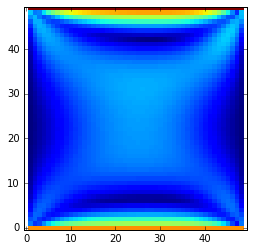

In [154]:
plt.imshow(np.sqrt(vx**2+vy**2),origin='top',interpolation='nearest')

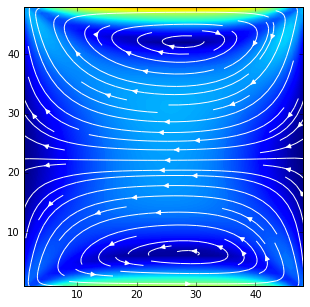

In [155]:
data = np.load("datasim/test.0.100.npz")
vx,vy = data['v']

ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0
plt.streamplot(X,Y,vx,vy,color='white')


In [157]:
import glob
frames = []

for fn in sorted(glob.glob("datasim/test*.npz")):
    data = np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    #vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])
print "Read ",(len(frames)),"files"

Read  101 files


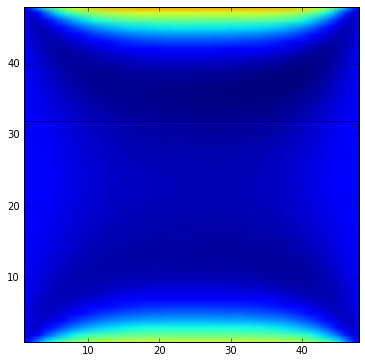

In [158]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
#from IPython.display import display,clear_output
ny,nx = frames[0][0].shape
@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=6),\
          sel=widgets.Dropdown(options=[('vx',0),('vy' , 1), ('rot v', 2),('rho',3)],value=0))
def g(ith,figsize,sel):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')
    plt.axhline(y=32, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show()